In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from math import comb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import random
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CosineAnnealingLR
from scipy.interpolate import splprep, splev
from torchvision import transforms

## CAE

### Configuration

In [9]:
IMAGE_SIZE = 672
LATENT_DIM = 128
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Convolutional Autoencoder (CAE) Implementation**

This section implements a Convolutional Autoencoder for:

- Learning compressed representations of fluid flow images

- Dimensionality reduction to latent space

- Image reconstruction capabilities

**The architecture includes:**

- Custom Encoder with convolutional layers

- Matching Decoder with transposed convolutions

- BCELoss for training

- Training/validation split with DataLoaders

In [10]:
# class FluidFlowDataset(Dataset):
#     """Custom PyTorch Dataset for fluid flow images.
#     Args:
#         root_dir (str): Directory containing image files
#         transform (callable, optional): Optional transform to apply
#     """
#     def __init__(self, root_dir, transform=None):
#         self.root_dir = root_dir
#         self.filenames = [f for f in os.listdir(root_dir) if f.endswith('.png')]
#         self.transform = transform
#         self.indices = []
        
#     def __len__(self):
#         return len(self.filenames)
    
#     def __getitem__(self, idx):
#         img_path = os.path.join(self.root_dir, self.filenames[idx])
#         img = Image.open(img_path)
#         img_array = np.array(img)  # (460, 648), 0 & 255
#         self.indices.append(idx)
        
        
#         img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0)  # (1, 460, 648)
        
#         if self.transform:
#             img_tensor = self.transform(img_tensor)
        
#         return img_tensor, 0 


class FluidFlowDataset(Dataset):
    """Custom PyTorch Dataset for fluid flow images.
    Args:
        root_dir (str): Directory containing image files
        transform (callable, optional): Optional transform to apply
    """
    def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.filenames = [f for f in os.listdir(root_dir) if f.endswith('.png')]
            self.transform = transform or transforms.Compose([
                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                transforms.ToTensor(),  # Converts to [0,1]
            ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.filenames[idx])
        img = Image.open(img_path).convert('L')  # ensure grayscale
        img = self.transform(img)  # (1, H, W)
        return img, 0  # dummy label

def get_dataloaders(root_dir, batch_size=32, val_size=0.20):
    """Creates training and validation DataLoaders for fluid flow images.
    
    Args:
        root_dir (str): Path to directory containing fluid flow images
        batch_size (int, optional): Number of samples per batch. Defaults to 32.
        val_size (float, optional): Proportion of dataset for validation (0-1). Defaults to 0.10.
        
    Returns:
        tuple: (train_loader, val_loader) where:
            - train_loader: DataLoader for training data with shuffling
            - val_loader: DataLoader for validation data without shuffling
    """
    dataset = FluidFlowDataset(root_dir=root_dir)
    
    train_data, val_data = train_test_split(
        dataset, test_size=val_size, random_state=42
    )
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

# def get_dataloaders(root_dir, batch_size=32, val_size=0.20):
#     """Creates training and validation DataLoaders for fluid flow images.
    
#     Args:
#         root_dir (str): Path to directory containing fluid flow images
#         batch_size (int, optional): Number of samples per batch. Defaults to 32.
#         val_size (float, optional): Proportion of dataset for validation (0-1). Defaults to 0.10.
        
#     Returns:
#         tuple: (train_loader, val_loader) where:
#             - train_loader: DataLoader for training data with shuffling
#             - val_loader: DataLoader for validation data without shuffling
#     """
#     dataset = FluidFlowDataset(root_dir=root_dir)
#     train_size = int((1 - val_size) * len(dataset))
#     val_size = len(dataset) - train_size
#     train_set, val_set = random_split(dataset, [train_size, val_size])
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
#     return train_loader, val_loader

### Model

In [11]:
# class Encoder(nn.Module):
#     """Convolutional encoder network for CAE.
#     Args:
#         latent_dim (int): Dimension of latent space representation
#     """
#     def __init__(self, latent_dim=64):
#         super().__init__()
        
#         self.conv_layers = nn.Sequential(
#             # (1, 460, 648) -> (16, 230, 324)
#             nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
            
#             # (16, 230, 324) -> (32, 115, 162)
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
#             nn.ReLU(),
            
#             # (32, 115, 162) -> (64, 58, 81)
#             nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
#             nn.ReLU(),
            
#             # (64, 58, 81) -> (128, 29, 41)
#             nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
#             nn.ReLU()
#         )
        
#         self._calculate_fc_input(latent_dim)
    
#     def _calculate_fc_input(self, latent_dim):
#         with torch.no_grad():
#             dummy_input = torch.zeros(1, 1, 460, 648)
#             dummy_output = self.conv_layers(dummy_input)
#             self.fc_input_dim = dummy_output.numel() // dummy_output.shape[0]
#             self.fc = nn.Linear(self.fc_input_dim, latent_dim)
    
#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

# class Decoder(nn.Module):
#     """Convolutional decoder network for CAE.
#     Args:
#         latent_dim (int): Dimension of latent space representation
#     """
#     def __init__(self, latent_dim=64):
#         super().__init__()
  
#         self.fc_output_dim = 128 * 29 * 41
#         self.fc = nn.Linear(latent_dim, self.fc_output_dim)
        
#         self.deconv_layers = nn.Sequential(
#             nn.Unflatten(1, (128, 29, 41)),
            
#             # (128, 29, 41) -> (64, 58, 82)
#             nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0),
#             nn.ReLU(),
            
#             # (64, 58, 82) -> (32, 116, 164)
#             nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),
#             nn.ReLU(),
            
#             # (32, 116, 164) -> (16, 232, 328)
#             nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0),
#             nn.ReLU(),
            
#             # (16, 232, 328) -> (1, 460, 648)
#             nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=1),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         x = self.fc(x)
#         return self.deconv_layers(x)

# class CAE(nn.Module):
#     """Complete Convolutional Autoencoder architecture.
#     Args:
#         latent_dim (int): Dimension of latent space representation
#     """
#     def __init__(self, latent_dim=64):
#         super().__init__()
#         self.encoder = Encoder(latent_dim)
#         self.decoder = Decoder(latent_dim)
    
#     def forward(self, x):
#         latent = self.encoder(x)
#         reconstructed = self.decoder(latent)
        
#         if reconstructed.shape[2:] != x.shape[2:]:
#             reconstructed = F.interpolate(reconstructed, size=x.shape[2:], mode='bilinear')
        
#         return reconstructed

class Encoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # 672 -> 336
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 336 -> 168
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # 168 -> 84
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),  # 84 -> 42
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),  # 42 -> 21
            nn.ReLU(),
        )
        self.flatten_dim = 512 * 21 * 21
        self.fc = nn.Linear(self.flatten_dim, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 512 * 21 * 21)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),  # 21 -> 42
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # 42 -> 84
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),   # 84 -> 168
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),    # 168 -> 336
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),     # 336 -> 672
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 512, 21, 21)
        return self.deconv(x)


class CAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [12]:
def plot_reconstruction(model, dataset_path, latent_dim=64, device='cuda'):
    """Visualizes original image, latent vector and reconstructed image.
    Args:
        model (CAE): Trained autoencoder model
        dataset_path (str): Path to image dataset
        latent_dim (int): Dimension of latent space
        device (str): Computation device ('cuda' or 'cpu')
    """
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    if not image_files:
        raise ValueError("There is no PNG images")
    
    random_image = random.choice(image_files)
    image_path = os.path.join(dataset_path, random_image)
    
    img = Image.open(image_path)
    img_array = np.array(img)  # (460, 648), 0 & 255
    img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        latent = model.encoder(img_tensor)
        reconstructed = model.decoder(latent)
    
    original_img = img_tensor[0].cpu().squeeze().numpy()  # [H, W]
    latent_vector = latent[0].cpu().numpy()               # [latent_dim]
    reconstructed_img = reconstructed[0].cpu().squeeze().numpy()  # [H, W]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Original Image: {random_image}")
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Latent Vector ({latent_dim} dim)")
    colors = ['r' if v < 0 else 'b' for v in latent_vector]
    plt.bar(range(latent_dim), latent_vector, color=colors)
    plt.xlabel("Dimension Index")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_img, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis for image: {random_image}")
    print(f"Latent vector shape: {latent_vector.shape}")
    print(f"Latent vector min/mean/max: {latent_vector.min():.4f}, {latent_vector.mean():.4f}, {latent_vector.max():.4f}")
    print("\nLatent values:")
    print(np.round(latent_vector, 4))

    return original_img, latent_vector, reconstructed_img

In [13]:
def plot_reconstruction_art(model, dataset_path, latent_dim=64, device='cuda'):
    """Visualizes original image, latent vector and reconstructed image.
    Args:
        model (CAE): Trained autoencoder model
        dataset_path (str): Path to image dataset
        latent_dim (int): Dimension of latent space
        device (str): Computation device ('cuda' or 'cpu')
    """
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    if not image_files:
        raise ValueError("There is no PNG images")
    
    random_image = random.choice(image_files)
    image_path = os.path.join(dataset_path, random_image)
    
    img = Image.open(image_path)
    img_array = np.array(img)  # (460, 648), 0 & 255
    img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        latent = model.encoder(img_tensor)
        reconstructed = model.decoder(latent)
    
    original_img = img_tensor[0].cpu().squeeze().numpy()  # [H, W]
    latent_vector = latent[0].cpu().numpy()               # [latent_dim]
    reconstructed_img = reconstructed[0].cpu().squeeze().numpy()  # [H, W]
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    colors = ['r' if v < 0 else 'b' for v in latent_vector]
    plt.bar(range(latent_dim), latent_vector, color=colors)
    plt.grid(True, alpha=0.3)
    plt.axis('off')
    
        
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis for image: {random_image}")
    print(f"Latent vector shape: {latent_vector.shape}")
    print(f"Latent vector min/mean/max: {latent_vector.min():.4f}, {latent_vector.mean():.4f}, {latent_vector.max():.4f}")
    print("\nLatent values:")
    print(np.round(latent_vector, 4))

    return original_img, latent_vector, reconstructed_img

In [14]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Для бинарных изображений (0 и 1)
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

def adaptive_threshold(recon):
    return (recon > recon.mean()).float()

### Training

**Training Process**

The training section demonstrates:

- 1000 epoch training loop

- Loss tracking for both training and validation sets

- Model checkpointing for best performance

- Progressive loss reduction over time

- Final achieved metrics

In [15]:
device = DEVICE
print(f'Device: {device}')
latent_dim = LATENT_DIM
batch_size = BATCH_SIZE
num_epochs = EPOCHS

root_dir = "dataset_2_img"
# train_loader, val_loader = get_dataloaders(root_dir, batch_size=batch_size)
# all_entries = os.listdir(root_dir)
# n_files = len(all_entries)
# print(f'Dataset size: {n_files}')
# print(f'Train size: {len(train_loader.dataset)}')
# print(f'Val size: {len(val_loader.dataset)}')
# del all_entries

#Model 
model = CAE(latent_dim=latent_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#Checkpoints
best_val_loss = np.inf
best_train_loss = np.inf
best_dice = 0

#History
train_history = []
val_history = []
dice_history = []
lr_history = []

Device: cuda


In [ ]:
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0.0
    for x, _ in train_loader:
        x = x.to(device)
        
        x_reconstructed = model(x)
        loss = criterion(x_reconstructed, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() #* x.size(0)
    
    train_loss /= len(train_loader) #.dataset)
    train_history.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    dice = 0.0
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            x_reconstructed = model(x)
            loss = criterion(x_reconstructed, x)
            val_loss += loss.item() #* x.size(0)
            dice += dice_coefficient(x.cpu(), (x_reconstructed > 0.5).float().cpu())
    
    val_loss /= len(val_loader) #.dataset)
    val_history.append(val_loss)
    dice /= len(val_loader) #.dataset)
    dice_history.append(dice)

    lr = scheduler.get_last_lr()
    lr_history.append(lr)

    scheduler.step(val_loss)

    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save(model.state_dict(), f"models_cae/best_train_cae.pth")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"models_cae/best_val_cae.pth")

    if dice > best_dice:
        best_dice = dice
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f} | Dice: {dice}")

print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f} | Best Dice: {best_dice}')


In [ ]:
print(f'Done!\nBest Train Loss: {best_train_loss:.5f} | Best Val Loss: {best_val_loss:.5f} | Best Dice: {best_dice}')

plt.figure(figsize=(21,8))

n_step = np.linspace(0,len(train_history),len(train_history))

plt.subplot(1,3,1)
plt.title('Losses')
plt.plot(n_step, train_history, label='train loss', color='b')
plt.plot(n_step, val_history, label='val loss', color='r')
plt.gca().set_yscale('log')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()

plt.subplot(1,3,2)
plt.title('Dice metric')
plt.plot(n_step, dice_history, label='dice', color='b')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()

plt.subplot(1,3,3)
plt.title('Learning rate')
plt.plot(n_step, lr_history, label='lr', color='b')
plt.grid(True, linestyle='--', color='gray', alpha=0.7)
plt.legend()

plt.show()

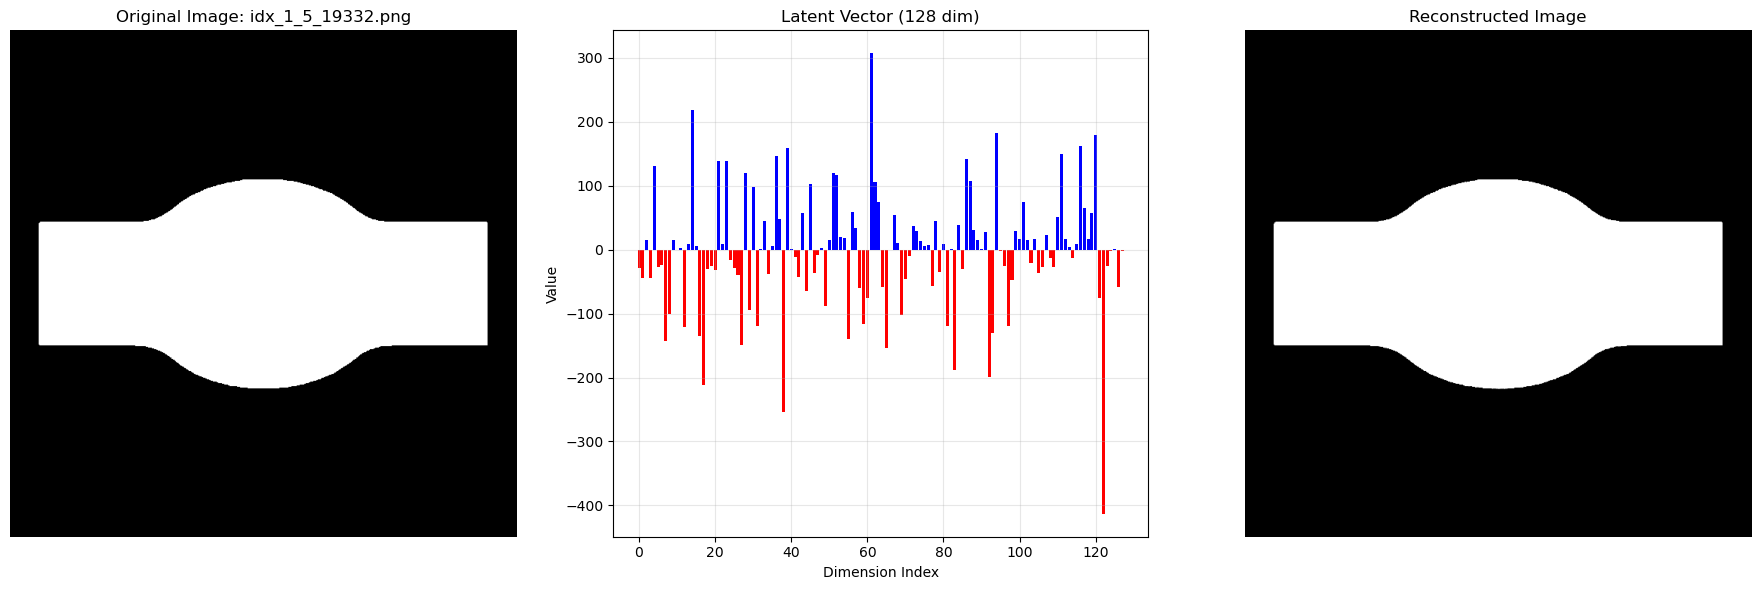


Analysis for image: idx_1_5_19332.png
Latent vector shape: (128,)
Latent vector min/mean/max: -412.9843, -2.9953, 307.2614

Latent values:
[ -27.9851  -43.659    15.7611  -43.8581  130.9206  -26.5305  -24.627
 -143.5287 -100.6173   15.5198   -1.1146    2.5041 -120.2884    9.5043
  218.8143    6.086  -134.6047 -211.6488  -29.5046  -25.2391  -31.7136
  139.032     8.4509  139.1826  -15.8769  -28.6557  -39.3954 -148.3335
  119.9255  -94.9913   98.4908 -119.214     1.4977   44.3293  -37.2882
    5.1689  146.1555   48.4884 -253.2802  159.8784    0.8631  -10.7776
  -42.8116   57.5122  -64.9295  102.2682  -35.7011   -7.7514    3.5032
  -88.4459   14.6569  119.5693  116.217    20.3926   19.0695 -140.0086
   59.1929   33.5516  -59.8995 -116.8829  -74.7587  307.2614  106.3866
   74.7128  -58.0895 -153.5084   -0.6461   53.9421   10.6688 -102.5717
  -45.3682   -9.1835   36.8401   29.5774   13.0531    6.5024    7.9962
  -56.2283   45.0983  -35.233     9.1384 -118.5344    1.3002 -188.0508
   38.929

In [21]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_train_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, root_dir, latent_dim=latent_dim, device=device)

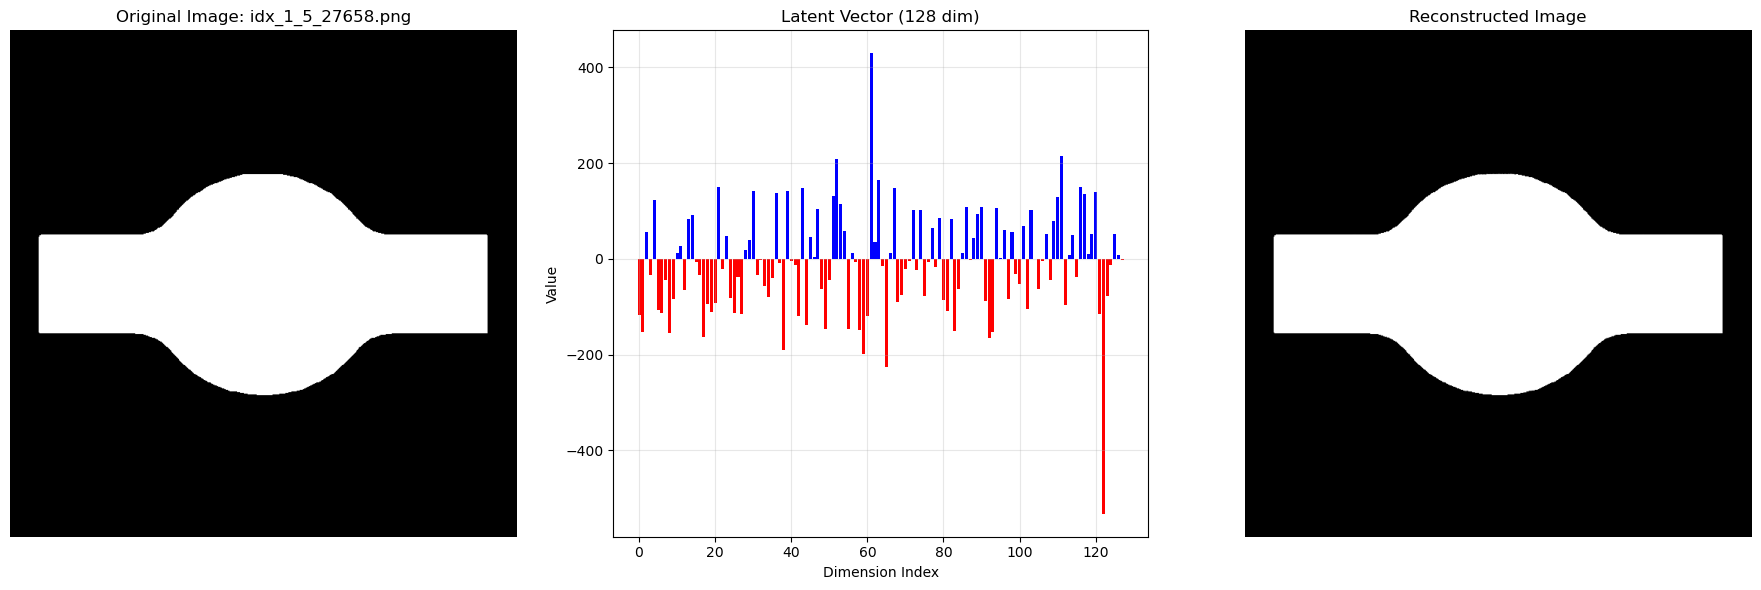


Analysis for image: idx_1_5_27658.png
Latent vector shape: (128,)
Latent vector min/mean/max: -532.3342, -7.6342, 429.1151

Latent values:
[-118.2516 -153.7699   56.1689  -34.5533  122.6713 -107.816  -113.6016
  -43.5618 -155.0385  -83.1702   11.8348   27.4517  -64.5929   83.9346
   91.032    -7.0662  -33.1194 -162.4569  -94.8383 -110.4774  -92.6398
  150.5455  -21.9391   47.5547  -82.4291 -112.9999  -38.0522 -115.8283
   18.8726   39.5342  142.0468  -33.024    -1.5037  -56.1962  -80.436
  -39.1585  136.9722   -8.6904 -190.8861  142.3632   -5.5895  -13.6304
 -120.2302  147.0615 -137.2993   46.067     3.5298  104.8914  -62.562
 -146.337   -44.1259  132.1269  208.0156  114.5072   58.3844 -147.3488
   13.0893   -6.6733 -148.1451 -198.4276 -120.0112  429.1152   34.7344
  164.1023  -15.1241 -225.549    11.9856  148.2154  -91.1167  -76.4676
  -21.3768   -3.7359  102.1421  -22.4447  102.1881  -78.2443   -5.7032
   64.7793  -18.0536   85.1326  -85.5047 -109.0834   82.6263 -150.2369
  -63.5658

In [23]:
model = CAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))
model.eval()

original_img, latent_vector, reconstructed_img = plot_reconstruction(model, root_dir, latent_dim=latent_dim, device=device)

In [ ]:
def get_latent_vectors(model, dataset_path, device='cuda'):
    """Extracts latent vectors for all images in dataset."""
    model.eval()
    latent_vectors = []
    filenames = []
    
    image_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]
    
    with torch.no_grad():
        for img_file in image_files:
            img_path = os.path.join(dataset_path, img_file)
            img = Image.open(img_path)
            img_array = np.array(img) / 255.0
            img_tensor = torch.FloatTensor(img_array).unsqueeze(0).unsqueeze(0).to(device)
            
            latent = model.encoder(img_tensor)
            latent_vectors.append(latent.cpu().numpy().squeeze())
            filenames.append(img_file)
    
    return np.array(latent_vectors), filenames

In [ ]:
def parse_filename_pairs(filenames):
    """Extracts pair indices from filenames like 'idx_1_2_50.png'."""
    pairs = []
    for name in filenames:
        parts = name.split('_')
        idx1, idx2 = int(parts[1]), int(parts[2])
        pairs.append((idx1, idx2))
    
    # Assign unique cluster ID to each pair
    unique_pairs = list(set(pairs))
    pair_to_cluster = {pair: i for i, pair in enumerate(unique_pairs)}
    cluster_ids = [pair_to_cluster[pair] for pair in pairs]
    
    return cluster_ids, unique_pairs

In [ ]:
from sklearn.manifold import TSNE

def reduce_dimensions(latent_vectors):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    return tsne.fit_transform(latent_vectors)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_clusters(tsne_results, cluster_ids, unique_pairs_count):
    plt.figure(figsize=(15, 10))
    palette = sns.color_palette("hsv", unique_pairs_count)
    
    scatter = plt.scatter(
        tsne_results[:, 0], 
        tsne_results[:, 1], 
        c=cluster_ids, 
        cmap='hsv', 
        alpha=0.7,
        s=10
    )
    
    plt.title('t-SNE Visualization of Latent Space Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

def reduce_dimensions(latent_vectors, n_samples):
    # Автоматическая настройка perplexity
    safe_perplexity = min(30, n_samples - 1)  # ограничение сверху
    tsne = TSNE(n_components=2, perplexity=safe_perplexity, random_state=42)
    return tsne.fit_transform(latent_vectors)

In [ ]:
model = CAE(latent_dim=128).to(device)
model.load_state_dict(torch.load("models_cae/best_val_cae.pth"))

# Извлечение данных
latent_vectors, filenames = get_latent_vectors(model, root_dir, device)

# Парсинг кластеров
cluster_ids, unique_pairs = parse_filename_pairs(filenames)
print(f"Уникальных пар: {len(unique_pairs)}")

# Применение t-SNE
tsne_results = reduce_dimensions(latent_vectors, n_samples=n_files)

# Визуализация
plot_tsne_clusters(tsne_results, cluster_ids, len(unique_pairs))

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_ids, cmap='viridis', alpha=0.6)
plt.title('PCA Visualization')
plt.show()

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)  # кластеры по числу пар
clusters = kmeans.fit_predict(latent_vectors)

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('PCA + K-Means Clustering')
plt.show()

In [31]:
image_path_1 = "dataset_2_img/idx_1_1_15000.png"
image_path_2 = "dataset_2_img/idx_5_5_15000.png"

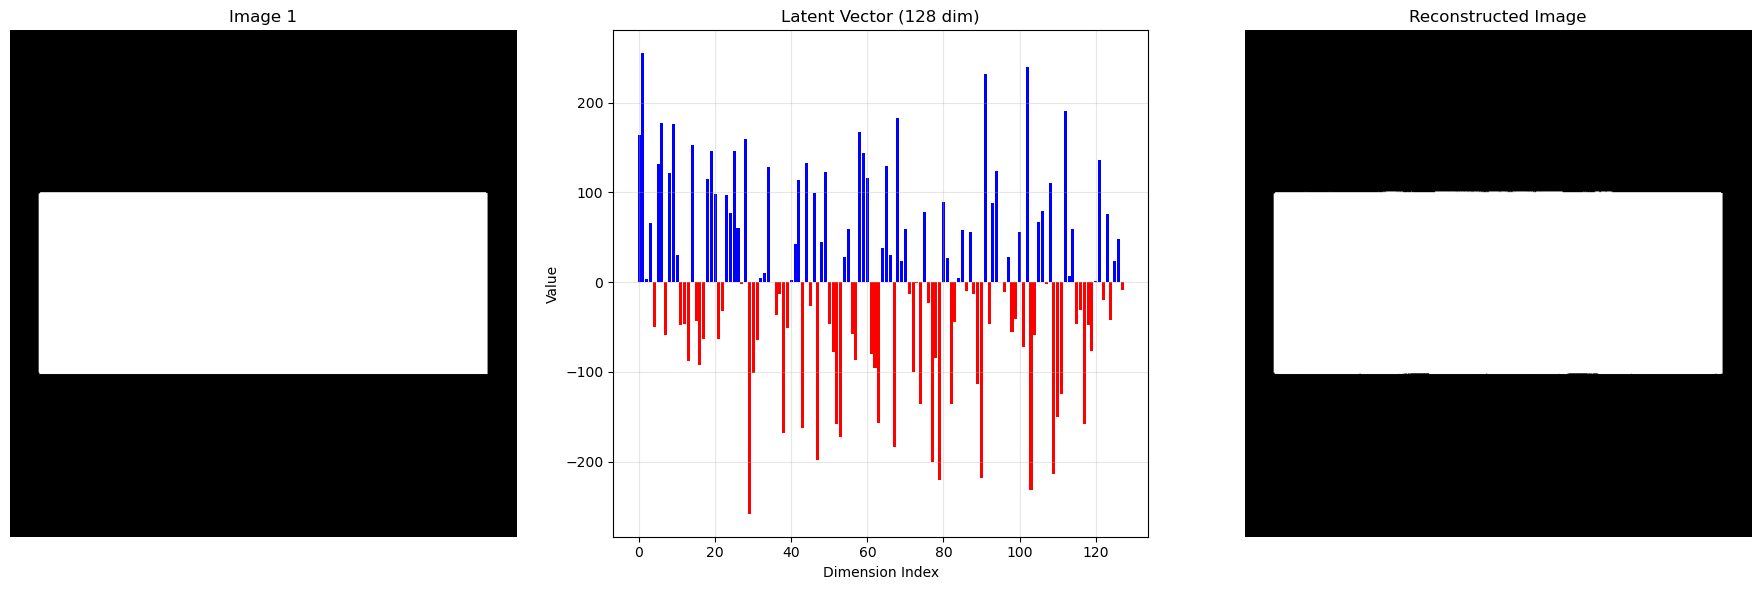

In [33]:
img_1 = Image.open(image_path_1)
img_array_1 = np.array(img_1)  # (460, 648), 0 & 255
img_tensor_1 = torch.from_numpy(img_array_1 / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    latent_1 = model.encoder(img_tensor_1)
    reconstructed_1 = model.decoder(latent_1)

original_img_1 = img_tensor_1[0].cpu().squeeze().numpy()  # [H, W]
latent_vector_1 = latent_1[0].cpu().numpy()               # [latent_dim]
reconstructed_img_1 = reconstructed_1[0].cpu().squeeze().numpy()  # [H, W]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title(f"Image 1")
plt.imshow(original_img_1, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Latent Vector ({latent_dim} dim)")
colors = ['r' if v < 0 else 'b' for v in latent_vector_1]
plt.bar(range(latent_dim), latent_vector_1, color=colors)
plt.xlabel("Dimension Index")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img_1, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

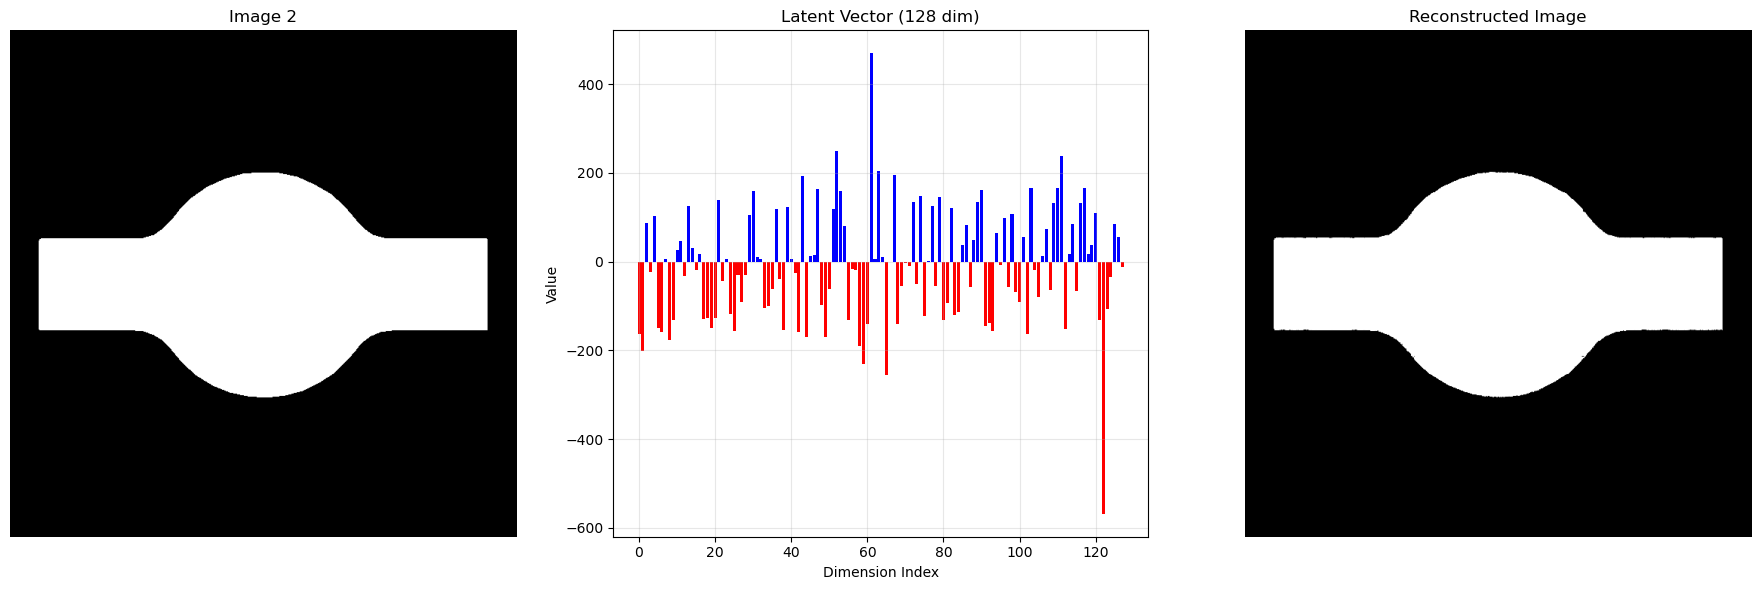

In [34]:
img_2 = Image.open(image_path_2)
img_array_2 = np.array(img_2)  # (460, 648), 0 & 255
img_tensor_2 = torch.from_numpy(img_array_2 / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    latent_2 = model.encoder(img_tensor_2)
    reconstructed_2 = model.decoder(latent_2)

original_img_2 = img_tensor_2[0].cpu().squeeze().numpy()  # [H, W]
latent_vector_2 = latent_2[0].cpu().numpy()               # [latent_dim]
reconstructed_img_2 = reconstructed_2[0].cpu().squeeze().numpy()  # [H, W]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title(f"Image 2")
plt.imshow(original_img_2, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"Latent Vector ({latent_dim} dim)")
colors = ['r' if v < 0 else 'b' for v in latent_vector_2]
plt.bar(range(latent_dim), latent_vector_2, color=colors)
plt.xlabel("Dimension Index")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img_2, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

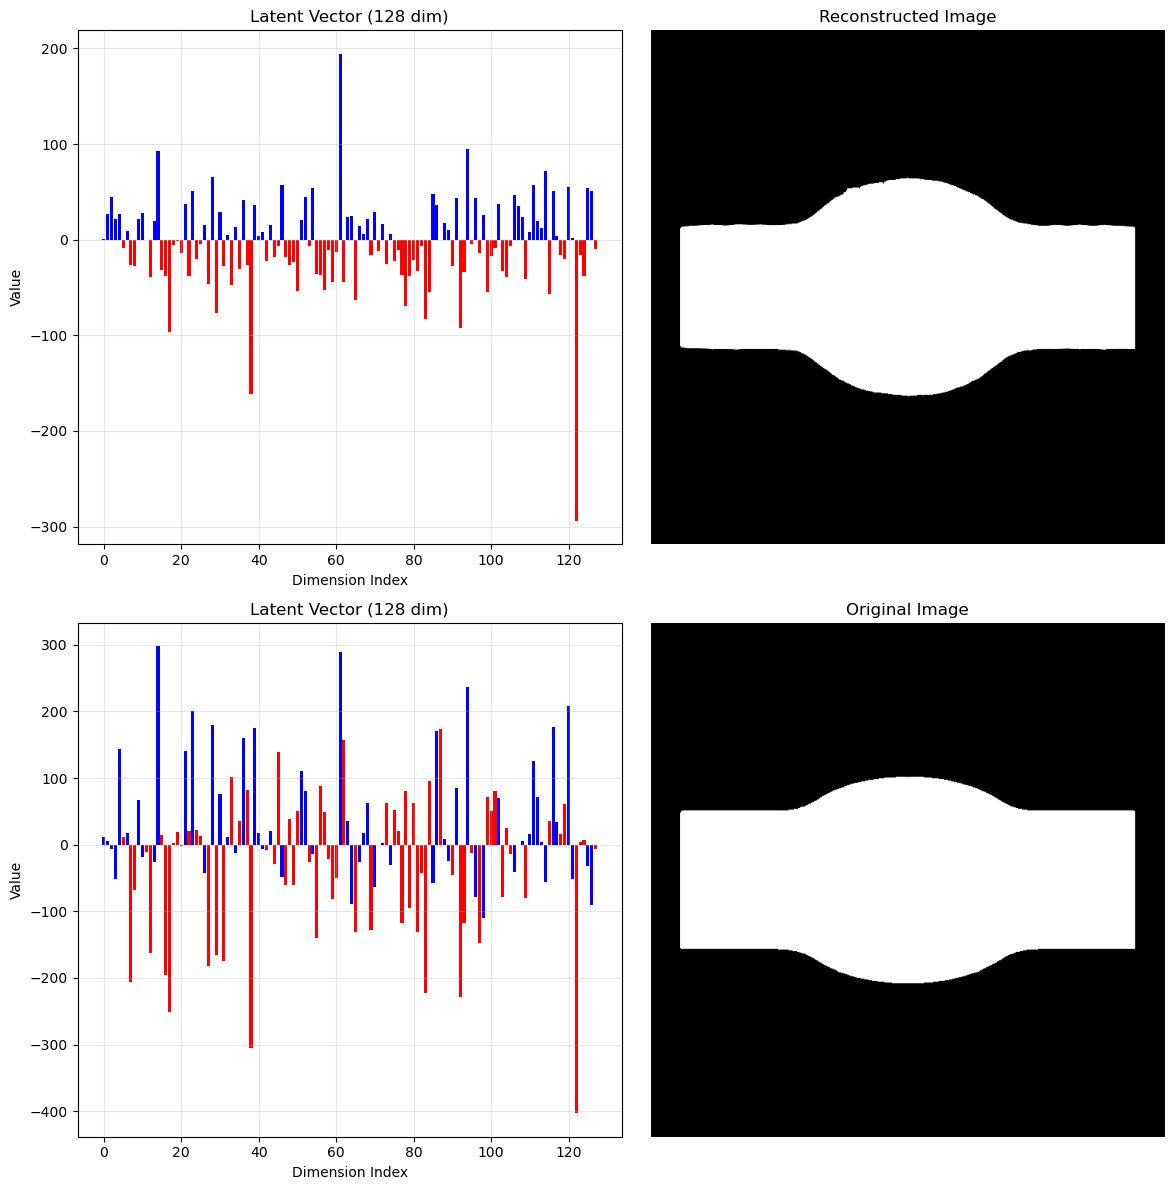

In [35]:
latent_vector_mix = torch.Tensor(0.5*(latent_vector_1 + latent_vector_2).reshape((1,128))).to(device)             # [latent_dim]
with torch.no_grad():
    reconstructed_mix = model.decoder(latent_vector_mix)

latent_vector_mix = latent_vector_mix[0].cpu().numpy() 
reconstructed_img_mix = reconstructed_mix[0].cpu().squeeze().numpy()  # [H, W]

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.title(f"Latent Vector ({latent_dim} dim)")
colors = ['r' if v < 0 else 'b' for v in latent_vector_mix]
plt.bar(range(latent_dim), latent_vector_mix, color=colors)
plt.xlabel("Dimension Index")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_img_mix, cmap='gray')
plt.axis('off')

#===============================
img = Image.open("dataset_2_img/idx_1_5_15001.png")
img_array = np.array(img)
img_tensor = torch.from_numpy(img_array / 255.0).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    latent = model.encoder(img_tensor)
    reconstructed = model.decoder(latent)

original_img = img_tensor[0].cpu().squeeze().numpy()  # [H, W]
latent_vector = latent[0].cpu().numpy()               # [latent_dim]
reconstructed_img = reconstructed[0].cpu().squeeze().numpy()

plt.subplot(2, 2, 3)
plt.title(f"Latent Vector ({latent_dim} dim)")
colors = ['r' if v < 0 else 'b' for v in latent_vector_mix]
plt.bar(range(latent_dim), latent_vector, color=colors)
plt.xlabel("Dimension Index")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.title("Original Image")
plt.imshow(reconstructed_img, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

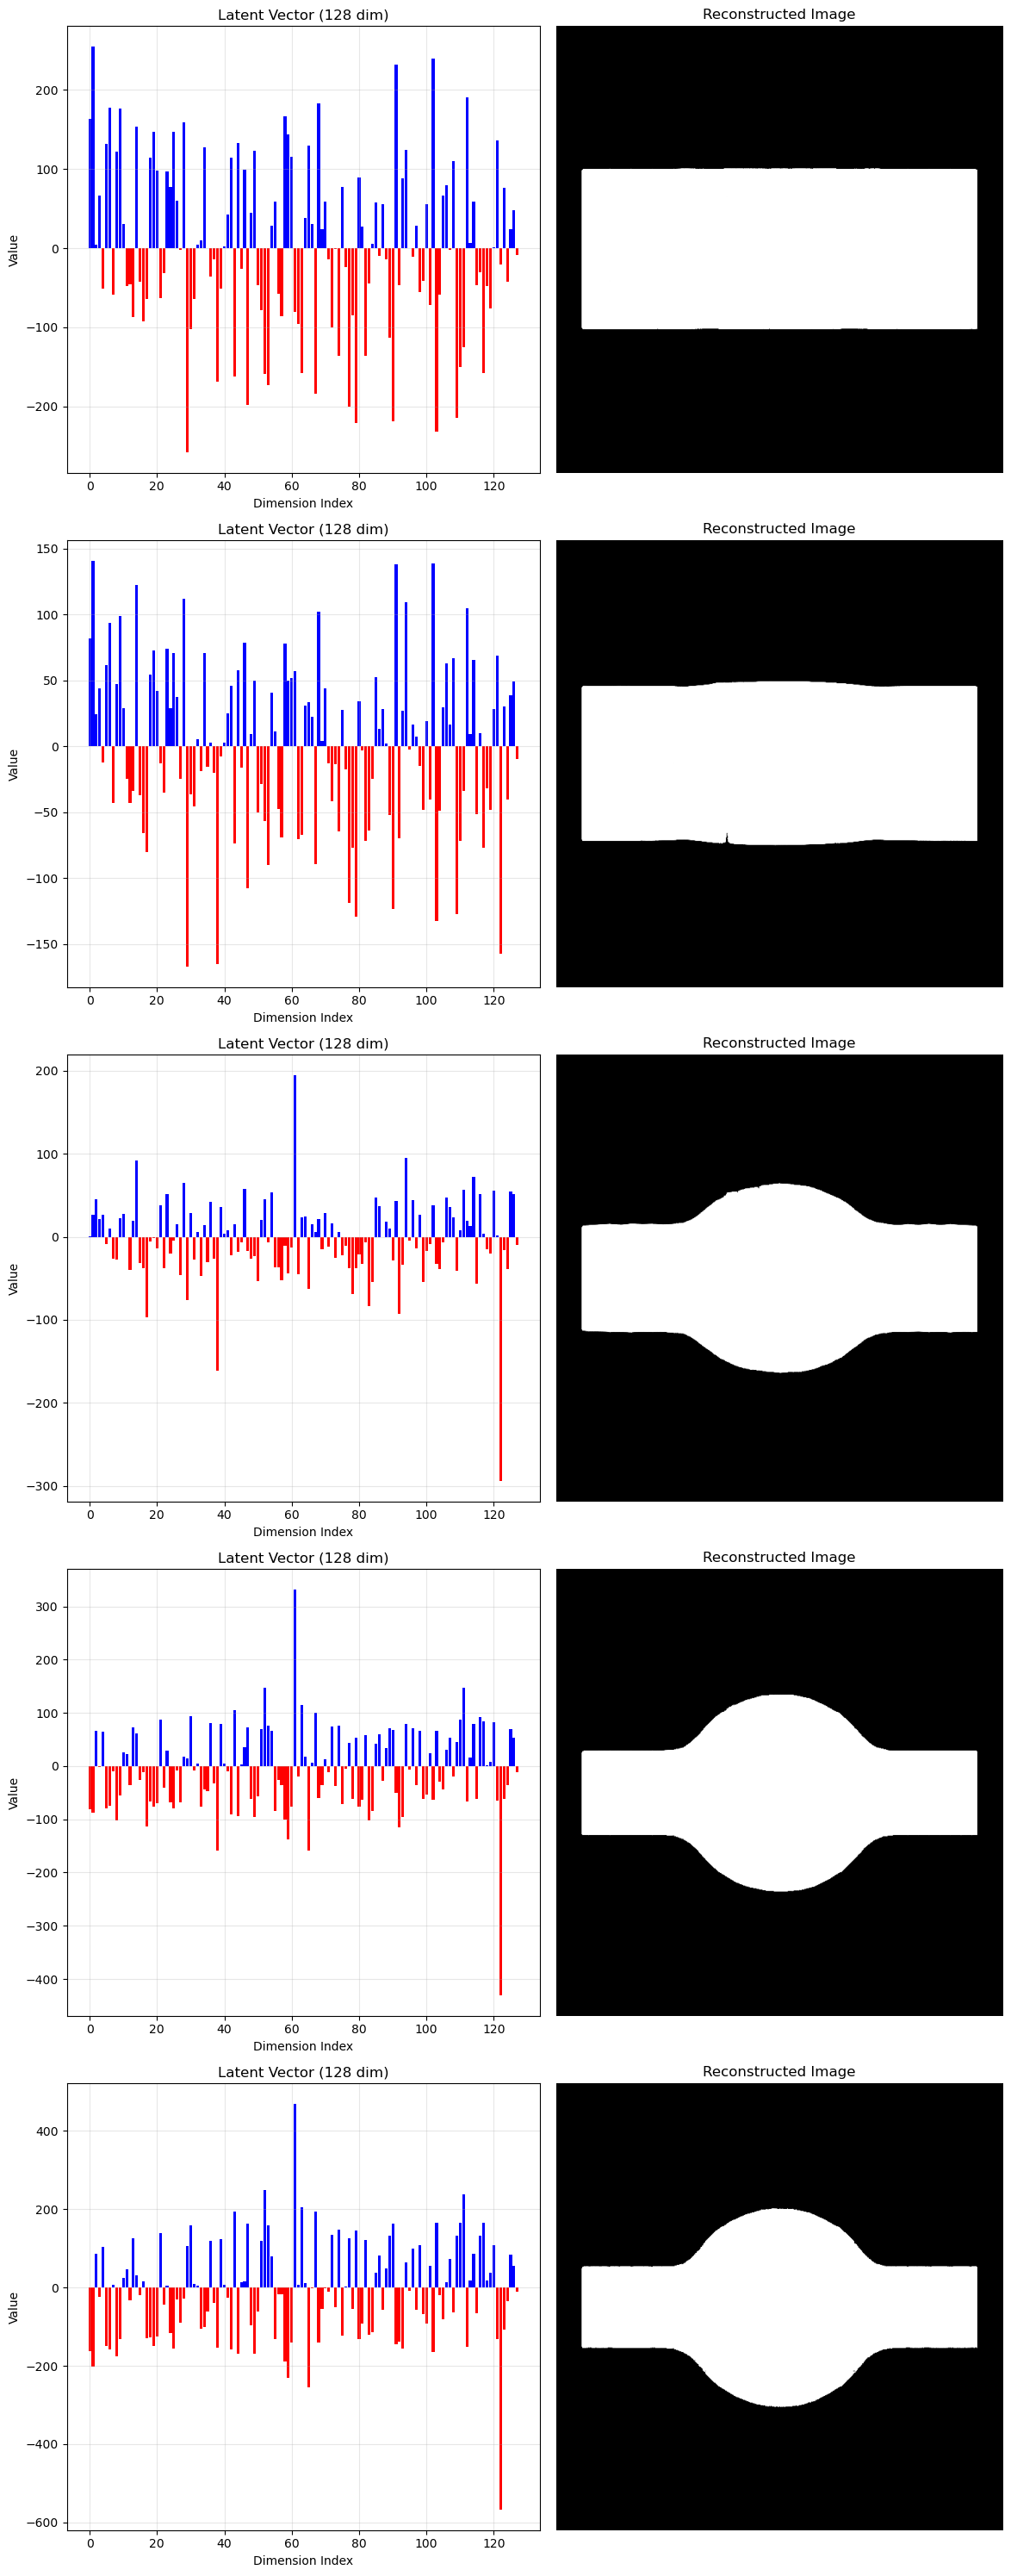

In [62]:
latent_vector_list = [torch.Tensor((latent_vector_1*(1-i/4) + latent_vector_2*(i/4)).reshape((1,128))).to(device) for i in range(5)]             # [latent_dim]


plt.figure(figsize=(12, 30))
for i, latent_vector_mix in enumerate(latent_vector_list):

    with torch.no_grad():
        reconstructed_mix = model.decoder(latent_vector_mix)

    latent_vector_mix = latent_vector_mix[0].cpu().numpy() 
    reconstructed_img_mix = reconstructed_mix[0].cpu().squeeze().numpy()  # [H, W]

    plt.subplot(5, 2, 2*i+1)
    plt.title(f"Latent Vector ({latent_dim} dim)")
    colors = ['r' if v < 0 else 'b' for v in latent_vector_mix]
    plt.bar(range(latent_dim), latent_vector_mix, color=colors)
    plt.xlabel("Dimension Index")
    plt.ylabel("Value")
    plt.grid(True, alpha=0.3)

    plt.subplot(5, 2, 2*i+2)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_img_mix, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

dataset_2_img_art\0.png
dataset_2_img_art\1.png
dataset_2_img_art\2.png
dataset_2_img_art\3.png
dataset_2_img_art\4.png


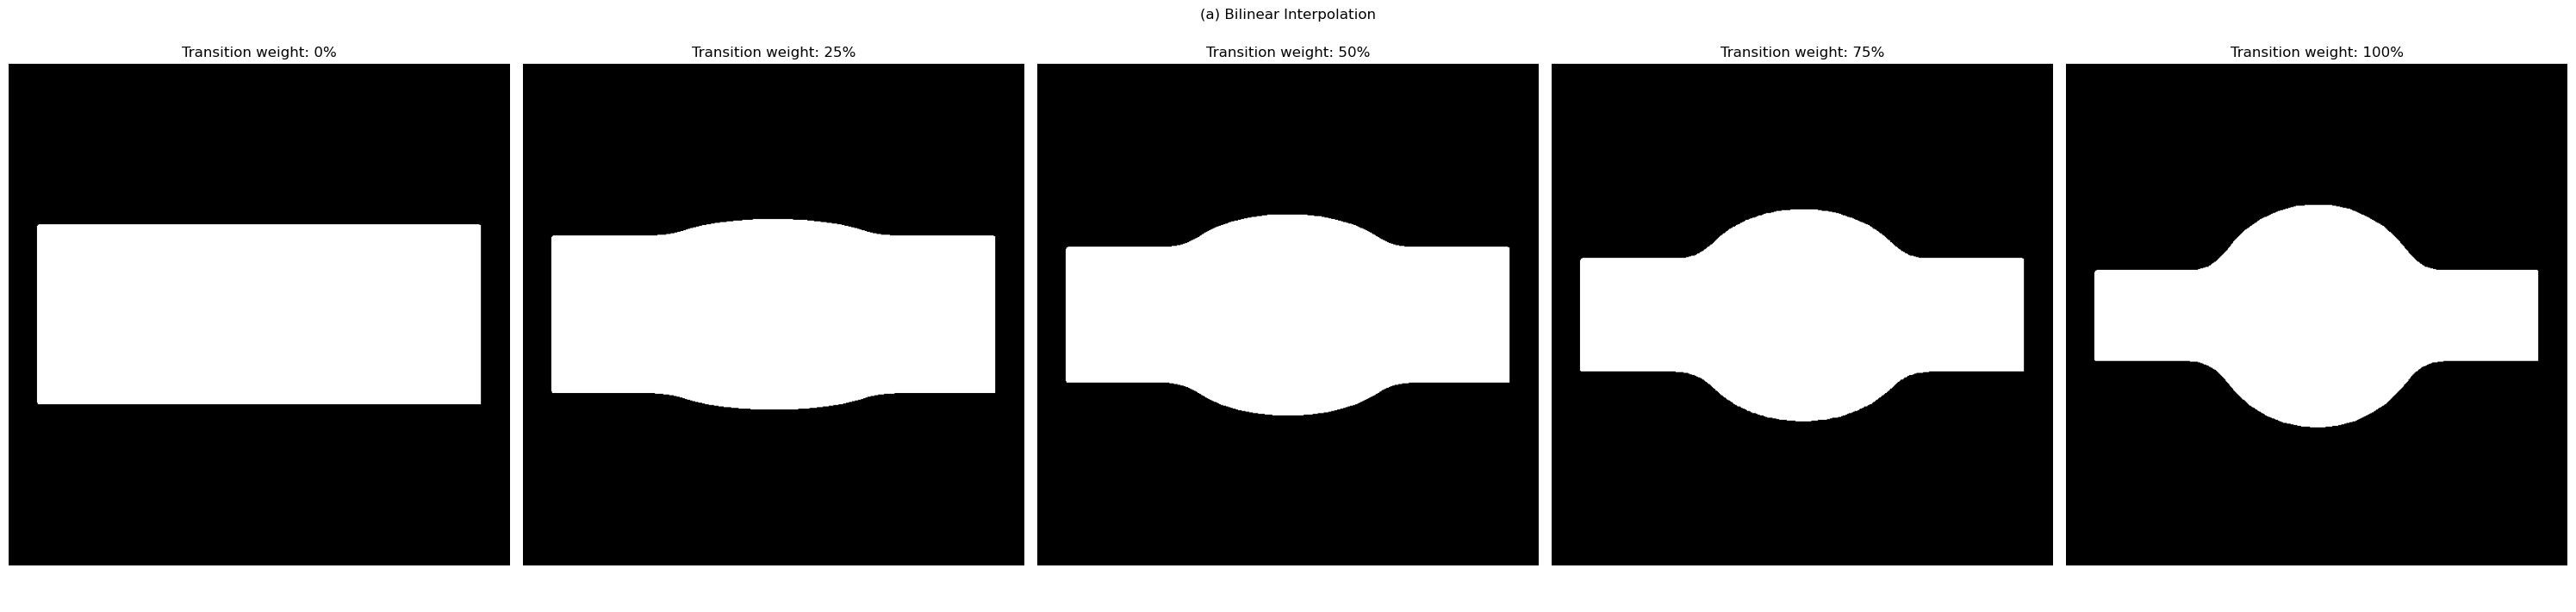

In [63]:
plt.figure(figsize=(30, 7))
plt.title('(a) Bilinear Interpolation')
plt.axis('off')
image_files = [f for f in os.listdir('dataset_2_img_art') if f.endswith('.png')]
for i, filename in enumerate(image_files):

    image_path = os.path.join('dataset_2_img_art', filename)
    print(image_path)
    img = Image.open(image_path)

    plt.subplot(1, 5, i+1)
    plt.title(f"Transition weight: {(i)*25}%")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

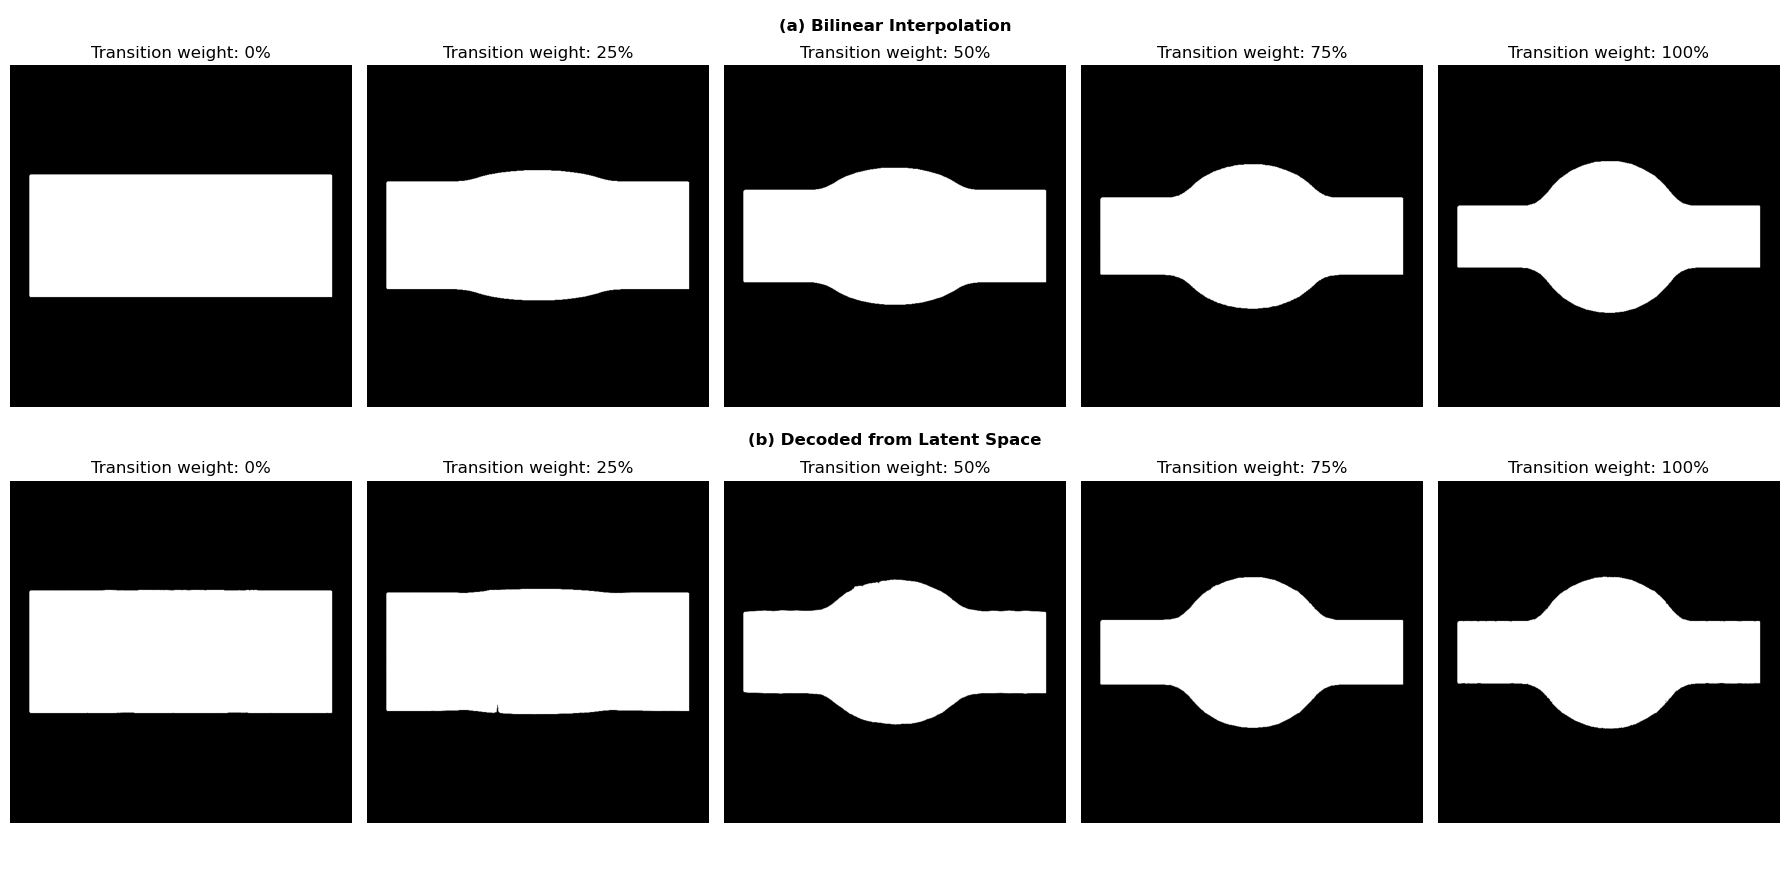

In [80]:
plt.figure(figsize=(18, 9))



#plt.title('(a) Bilinear Interpolation')
plt.figtext(0.5,
            0.96,
            "(a) Bilinear Interpolation", 
            ha="center",
            fontsize=12,
            fontweight = 'bold')

plt.axis('off')
image_files = [f for f in os.listdir('dataset_2_img_art') if f.endswith('.png')]
for i, filename in enumerate(image_files):

    image_path = os.path.join('dataset_2_img_art', filename)
    img = Image.open(image_path)

    plt.subplot(2, 5, i+1)
    plt.title(f"Transition weight: {(i)*25}%")
    plt.imshow(img, cmap='gray')
    plt.axis('off')


plt.figtext(0.5,
            0.5,
            "(b) Decoded from Latent Space", 
            ha="center",
            fontsize=12,
            fontweight='bold')

latent_vector_list = [torch.Tensor((latent_vector_1*(1-i/4) + latent_vector_2*(i/4)).reshape((1,128))).to(device) for i in range(5)]             # [latent_dim]

for i, latent_vector_mix in enumerate(latent_vector_list):

    with torch.no_grad():
        reconstructed_mix = model.decoder(latent_vector_mix)

    latent_vector_mix = latent_vector_mix[0].cpu().numpy() 
    reconstructed_img_mix = reconstructed_mix[0].cpu().squeeze().numpy()  # [H, W]

    plt.subplot(2, 5, i+6)
    plt.title(f"Transition weight: {(i)*25}%")
    plt.imshow(reconstructed_img_mix, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()